<a href="https://colab.research.google.com/github/babak-tafreshi/AER850_Project2/blob/main/Project2_AER850.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# AER 850 Project 2
# Babak Nassir Tafreshi

In [2]:
# Setting up the environment


import os, pathlib, json, math, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow: 2.19.0
GPU available: True


# Step 1: Data Processing
Data processing is the first step to perform any type of image classification task. There are a few steps involved with this step.

• The first is to define the input image shape which is required to be (500,500, 3) which is the desired width, height and channel of the image for model training.

• Establish the train and validation data directory (use relative paths). The data is split into 3 folders - Train, Validation and Test which contain 1942, 431 and 539 images respectively.

• Perform data augmentation such as re-scaling, shear range and zoom range by using packages such as Keras’ image preprocessing pipeline, or torchvision transforms for the train data and validation data (only apply re-scaling for validation).

• Create the train and validation generator using Keras’s built-in imagedatasetfromdirectory function which takes in the data directory, image target size, batch size (32), and class mode (categorical) or by using PyTorch’s Dataloader.

In [3]:
# =========================
# AER850 Project - STEP 1: Data Processing (Keras + ImageDataGenerator)
# Colab-ready, reproducible, and matches assignment requirements
# =========================

import os, json, math, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------- USER: FILL THESE (use RELATIVE paths in your repo structure if possible) ---------
PATH_TRAIN = "/content/drive/MyDrive/AER 850/Project 2/train"        # e.g., "data/train"
PATH_VAL   = "/content/drive/MyDrive/AER 850/Project 2/valid"          # e.g., "data/val"
PATH_TEST  = "/content/drive/MyDrive/AER 850/Project 2/test"         # e.g., "data/test"
# -------------------------------------------------------------------------------------------

# Safety check for paths (friendly message, not a hard crash until you run the generators)
for p in [PATH_TRAIN, PATH_VAL, PATH_TEST]:
    if not isinstance(p, str) or p.strip() == "":
        raise ValueError("Please set PATH_TRAIN, PATH_VAL, PATH_TEST to your directories (relative paths).")
    if not os.path.isdir(p):
        print(f"[WARN] Directory not found yet: {p}. If you're on Colab, mount Drive and/or fix the paths.")

# -----------------------
# Reproducibility settings
# -----------------------
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.config.experimental.enable_op_determinism()

# -----------------------
# Core parameters
# -----------------------
IMG_HEIGHT, IMG_WIDTH, IMG_CH = 500, 500, 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CH)
BATCH_SIZE  = 32
COLOR_MODE  = "rgb"
CLASS_MODE  = "categorical"   # 3 classes

print(f"[INFO] Input shape: {INPUT_SHAPE} | Batch size: {BATCH_SIZE} | Class mode: {CLASS_MODE}")

# -----------------------
# ImageDataGenerators
# -----------------------
# Train: rescale + augment (shear, zoom, small rotations/translations, optional flips)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.15,           # satisfies "shear range" requirement
    zoom_range=0.15,            # satisfies "zoom range" requirement
    rotation_range=12,          # small, realistic rotations
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation: rescale only (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# Test: rescale only (for later Step 5; we define the generator now for counts & consistency)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# -----------------------
# Directory iterators
# -----------------------
# Each expects subfolders named exactly after the classes (crack, missing-head, paint-off)
# Shuffle train, do not shuffle val/test.
train_gen = train_datagen.flow_from_directory(
    directory=PATH_TRAIN,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    directory=PATH_VAL,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    directory=PATH_TEST,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

# -----------------------
# Class mapping & save
# -----------------------
class_indices = train_gen.class_indices          # dict: {class_name: index}
inv_class_indices = {v: k for k, v in class_indices.items()}

print("\n[INFO] Class indices:", class_indices)
print("[INFO] Inverse map:  ", inv_class_indices)

# Save label map for later inference (Step 5)
os.makedirs("outputs", exist_ok=True)
with open("outputs/label_map.json", "w") as f:
    json.dump(class_indices, f, indent=2)
print('[INFO] Saved label map to "outputs/label_map.json"')

# -----------------------
# Dataset size checks
# -----------------------
n_train = train_gen.samples
n_val   = val_gen.samples
n_test  = test_gen.samples

print(f"\n[INFO] Sample counts -> Train: {n_train} | Val: {n_val} | Test: {n_test}")
EXPECTED = {"train": 1942, "val": 431, "test": 539}
for name, n, exp in [("Train", n_train, EXPECTED["train"]),
                     ("Val",   n_val,   EXPECTED["val"]),
                     ("Test",  n_test,  EXPECTED["test"])]:
    if n != exp:
        print(f"[WARN] {name} count is {n}, expected {exp}. Double-check your folders/files.")

# -----------------------
# Steps per epoch (ceil)
# -----------------------
steps_per_epoch      = int(math.ceil(n_train / BATCH_SIZE)) if n_train > 0 else 0
validation_steps     = int(math.ceil(n_val   / BATCH_SIZE)) if n_val   > 0 else 0
test_steps           = int(math.ceil(n_test  / BATCH_SIZE)) if n_test  > 0 else 0

print(f"\n[INFO] steps_per_epoch:   {steps_per_epoch}")
print(f"[INFO] validation_steps:  {validation_steps}")
print(f"[INFO] test_steps:        {test_steps}")

# Quick sanity batch to ensure pipeline works (only if there are samples)
if n_train > 0:
    xb, yb = next(iter(train_gen))
    print(f"\n[INFO] One training batch -> x: {xb.shape}, y: {yb.shape}, dtype: {xb.dtype}")
    assert xb.shape[1:] == (IMG_HEIGHT, IMG_WIDTH, IMG_CH), "Batch image shape mismatch!"
    assert yb.shape[1] == 3, "Expecting 3 classes (softmax outputs)."
else:
    print("\n[INFO] Skipped sanity batch: no training samples found yet.")


[INFO] Input shape: (500, 500, 3) | Batch size: 32 | Class mode: categorical
Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Found 539 images belonging to 3 classes.

[INFO] Class indices: {'crack': 0, 'missing-head': 1, 'paint-off': 2}
[INFO] Inverse map:   {0: 'crack', 1: 'missing-head', 2: 'paint-off'}
[INFO] Saved label map to "outputs/label_map.json"

[INFO] Sample counts -> Train: 1942 | Val: 431 | Test: 539

[INFO] steps_per_epoch:   61
[INFO] validation_steps:  14
[INFO] test_steps:        17

[INFO] One training batch -> x: (32, 500, 500, 3), y: (32, 3), dtype: float32


# STEP 2

In [4]:
# =========================
# AER850 Project - STEP 2: Neural Network Architecture Design
# Two custom CNN variants (A baseline, B improved), compiled and summarized
# =========================

import os, json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     LeakyReLU)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# -----------------------
# Inherit shape/classes from Step 1 if available; else default
# -----------------------
DEFAULT_INPUT_SHAPE = (500, 500, 3)
DEFAULT_NUM_CLASSES = 3

INPUT_SHAPE = DEFAULT_INPUT_SHAPE
NUM_CLASSES = DEFAULT_NUM_CLASSES

# If Step 1 ran, try to reuse its variables
try:
    # If train_gen exists, derive num classes from it.
    if 'train_gen' in globals() and hasattr(train_gen, 'num_classes'):
        NUM_CLASSES = int(train_gen.num_classes)
    # If INPUT_SHAPE existed in Step 1, keep it
    if 'INPUT_SHAPE' in globals():
        INPUT_SHAPE = tuple(INPUT_SHAPE)
except Exception:
    pass

print(f"[INFO] Using INPUT_SHAPE={INPUT_SHAPE}, NUM_CLASSES={NUM_CLASSES}")

# -----------------------
# Building blocks
# -----------------------
def conv_block(x, filters, k=3, s=1, use_bn=False, activation='relu', name_prefix='cb'):
    """A simple Conv2D -> (BN) -> Activation -> MaxPool block."""
    x = Conv2D(filters, kernel_size=(k, k), strides=(s, s), padding='same',
               kernel_initializer='he_normal', name=f'{name_prefix}_conv')(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.1, name=f'{name_prefix}_lrelu')(x)
    else:
        x = tf.keras.layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return x

def dense_head(x, units=128, dropout=0.5, use_bn=False, activation='relu',
               num_classes=3, l2_reg=None, name_prefix='head'):
    """Flatten -> Dense(units) -> (BN) -> Activation -> Dropout -> Dense(num_classes, softmax)"""
    x = Flatten(name=f'{name_prefix}_flatten')(x)
    kwargs = {}
    if l2_reg is not None and l2_reg > 0:
        kwargs['kernel_regularizer'] = l2(l2_reg)
    x = Dense(units, name=f'{name_prefix}_dense', **kwargs)(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if activation == 'elu':
        x = tf.keras.layers.Activation('elu', name=f'{name_prefix}_elu')(x)
    else:
        x = tf.keras.layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    if dropout and dropout > 0:
        x = Dropout(dropout, name=f'{name_prefix}_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    return outputs

# -----------------------
# Variant A (Baseline): Simple, clean CNN
# -----------------------
def build_cnn_variant_a(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Baseline: 4 conv blocks with filters [32, 64, 128, 256], ReLU, no BN,
    Flatten -> Dense(128, relu) -> Dropout(0.5) -> Dense(3, softmax)
    """
    inputs = Input(shape=input_shape, name='input')
    x = conv_block(inputs, 32, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb1')
    x = conv_block(x,      64, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb2')
    x = conv_block(x,     128, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb3')
    x = conv_block(x,     256, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb4')
    outputs = dense_head(x, units=128, dropout=0.5, use_bn=False,
                         activation='relu', num_classes=num_classes,
                         l2_reg=None, name_prefix='a_head')
    model = Model(inputs, outputs, name='CNN_Variant_A_Baseline')
    return model

# -----------------------
# Variant B (Improved): BN, LeakyReLU in convs, stronger regularization
# -----------------------
def build_cnn_variant_b(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Improved: 4 conv blocks with filters [64, 128, 256, 256], BatchNorm, LeakyReLU,
    Flatten -> Dense(256, ELU) -> Dropout(0.6) -> Dense(3, softmax).
    Slight L2 on dense to discourage overfitting.
    """
    inputs = Input(shape=input_shape, name='input')
    x = conv_block(inputs,  64, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb1')
    x = conv_block(x,      128, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb2')
    x = conv_block(x,      256, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb3')
    x = conv_block(x,      256, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb4')
    outputs = dense_head(x, units=256, dropout=0.6, use_bn=True,
                         activation='elu', num_classes=num_classes,
                         l2_reg=1e-4, name_prefix='b_head')
    model = Model(inputs, outputs, name='CNN_Variant_B_Improved')
    return model

# -----------------------
# Build and compile both
# -----------------------
os.makedirs("models", exist_ok=True)

model_a = build_cnn_variant_a()
model_b = build_cnn_variant_b()

# Default compile (Step 3 will explore alternatives)
model_a.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_b.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Print summaries
print("\n" + "="*80)
print("Model A (Baseline) Summary")
print("="*80)
model_a.summary()
print("\n" + "="*80)
print("Model B (Improved) Summary")
print("="*80)
model_b.summary()

# -----------------------
# Optional quick forward-pass sanity check (batch=1 to avoid memory spikes)
# -----------------------
try:
    dummy = np.random.rand(1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]).astype('float32')
    pa = model_a.predict(dummy, verbose=0)
    pb = model_b.predict(dummy, verbose=0)
    assert pa.shape == (1, NUM_CLASSES) and pb.shape == (1, NUM_CLASSES), "Output shape mismatch."
    print("\n[INFO] Sanity forward pass OK. Outputs:", pa.shape, pb.shape)
except Exception as e:
    print(f"\n[WARN] Sanity forward pass skipped/failed: {e}")


[INFO] Using INPUT_SHAPE=(500, 500, 3), NUM_CLASSES=3

Model A (Baseline) Summary


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "CNN_Variant_A_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb1_conv (Conv2D)             │ (None, 500, 500, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb1_relu (Activation)         │ (None, 500, 500, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb1_pool (MaxPooling2D)       │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb2_conv (Conv2D)             │ (None, 250, 250, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb2_relu (Activation)         │ (None, 250, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb2_pool (MaxPooling2D)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb3_conv (Conv2D)             │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb3_relu (Activation)         │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb3_pool (MaxPooling2D)       │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb4_conv (Conv2D)             │ (None, 62, 62, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb4_relu (Activation)         │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb4_pool (MaxPooling2D)       │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_flatten (Flatten)        │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_dense (Dense)            │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_relu (Activation)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_dropout (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,878,979 (121.61 MB)

 Trainable params: 31,878,979 (121.61 MB)

 Non-trainable params: 0 (0.00 B)


Model B (Improved) Summary


Model: "CNN_Variant_B_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_conv (Conv2D)             │ (None, 500, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_bn (BatchNormalization)   │ (None, 500, 500, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_lrelu (LeakyReLU)         │ (None, 500, 500, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_pool (MaxPooling2D)       │ (None, 250, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_conv (Conv2D)             │ (None, 250, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_bn (BatchNormalization)   │ (None, 250, 250, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_lrelu (LeakyReLU)         │ (None, 250, 250, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_pool (MaxPooling2D)       │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_conv (Conv2D)             │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_bn (BatchNormalization)   │ (None, 125, 125, 256)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_lrelu (LeakyReLU)         │ (None, 125, 125, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_pool (MaxPooling2D)       │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_conv (Conv2D)             │ (None, 62, 62, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_bn (BatchNormalization)   │ (None, 62, 62, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_lrelu (LeakyReLU)         │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_pool (MaxPooling2D)       │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_flatten (Flatten)        │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_dense (Dense)            │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_bn (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_elu (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_dropout (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,945,859 (243.93 MB)

 Trainable params: 63,943,939 (243.93 MB)

 Non-trainable params: 1,920 (7.50 KB)


[INFO] Sanity forward pass OK. Outputs: (1, 3) (1, 3)


# STEP 3

In [5]:
# =========================
# AER850 Project - STEP 3: Hyperparameter Analysis (setup only)
# - Define a small, meaningful hyperparameter search space
# - Build & compile candidate models
# - Print a compact summary table for quick comparison
# Training/evaluation will be in STEP 4.
# =========================

import os, math, json, pprint
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization, LeakyReLU, Activation)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd

# -----------------------
# Safe defaults / inherit from Step 1
# -----------------------
DEFAULT_INPUT_SHAPE = (500, 500, 3)
DEFAULT_NUM_CLASSES = 3

INPUT_SHAPE = DEFAULT_INPUT_SHAPE
NUM_CLASSES = DEFAULT_NUM_CLASSES

try:
    if 'INPUT_SHAPE' in globals() and isinstance(INPUT_SHAPE, tuple):
        INPUT_SHAPE = tuple(INPUT_SHAPE)
    if 'train_gen' in globals() and hasattr(train_gen, 'num_classes'):
        NUM_CLASSES = int(train_gen.num_classes)
except Exception:
    pass

print(f"[INFO] Hyperparam setup using INPUT_SHAPE={INPUT_SHAPE}, NUM_CLASSES={NUM_CLASSES}")

# -----------------------
# Building blocks (conv block + dense head) following assignment (uses Flatten)
# -----------------------
def conv_block(x, filters, k=3, s=1, use_bn=False, conv_activation='relu', name_prefix='cb'):
    x = Conv2D(filters, (k, k), strides=(s, s), padding='same',
               kernel_initializer='he_normal', name=f'{name_prefix}_conv')(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if conv_activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.1, name=f'{name_prefix}_lrelu')(x)
    else:
        x = Activation('relu', name=f'{name_prefix}_relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return x

def dense_head(x, dense_units=128, dropout=0.5, use_bn=False,
               dense_activation='relu', num_classes=3, l2_reg=None, name_prefix='head'):
    x = Flatten(name=f'{name_prefix}_flatten')(x)
    kwargs = {}
    if l2_reg is not None and l2_reg > 0:
        kwargs['kernel_regularizer'] = l2(l2_reg)
    x = Dense(dense_units, name=f'{name_prefix}_dense', **kwargs)(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if dense_activation == 'elu':
        x = Activation('elu', name=f'{name_prefix}_elu')(x)
    else:
        x = Activation('relu', name=f'{name_prefix}_relu')(x)
    if dropout and dropout > 0:
        x = Dropout(dropout, name=f'{name_prefix}_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    return outputs

def build_custom_cnn(hp):
    """
    hp dict keys (examples):
      - filters: [32,64,128,256]
      - kernel_size: 3
      - use_bn: True/False
      - conv_activation: 'relu' or 'leaky_relu'
      - dense_units: 128/256
      - dense_activation: 'relu' or 'elu'
      - dropout: 0.5/0.6
      - l2_reg: float or None
    """
    inputs = Input(shape=INPUT_SHAPE, name='input')
    x = inputs
    for i, f in enumerate(hp['filters'], start=1):
        x = conv_block(
            x, filters=f, k=hp.get('kernel_size', 3), s=1,
            use_bn=hp.get('use_bn', False),
            conv_activation=hp.get('conv_activation', 'relu'),
            name_prefix=f"cb{i}"
        )
    outputs = dense_head(
        x,
        dense_units=hp.get('dense_units', 128),
        dropout=hp.get('dropout', 0.5),
        use_bn=hp.get('use_bn_head', False),
        dense_activation=hp.get('dense_activation', 'relu'),
        num_classes=NUM_CLASSES,
        l2_reg=hp.get('l2_reg', None),
        name_prefix="head"
    )
    model = Model(inputs, outputs, name=hp.get('name', 'CustomCNN'))
    return model

def make_optimizer(name='adam', lr=1e-3):
    name = name.lower()
    if name == 'adam':
        return Adam(learning_rate=lr)
    if name == 'sgd':
        return SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    if name == 'rmsprop':
        return RMSprop(learning_rate=lr, rho=0.9, momentum=0.0)
    raise ValueError(f"Unknown optimizer '{name}'")

# -----------------------
# Hyperparameter candidates (small, meaningful grid)
# - A: ReLU conv + ReLU dense, modest filters, Adam 1e-3
# - B: LeakyReLU conv + ELU dense, stronger filters, BN, Dropout 0.6, L2, Adam 1e-3
# - C: ReLU conv + ELU dense, slightly bigger dense head, SGD (to compare optimizer behavior)
# - D: LeakyReLU conv, same as B but with RMSprop + different LR
# -----------------------
HP_TRIALS = [
    {
        "name": "A_relu_relu_32-64-128-256_adam1e-3",
        "filters": [32, 64, 128, 256],
        "kernel_size": 3,
        "use_bn": False,
        "use_bn_head": False,
        "conv_activation": "relu",
        "dense_units": 128,
        "dense_activation": "relu",
        "dropout": 0.5,
        "l2_reg": None,
        "optimizer": "adam",
        "lr": 1e-3,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
    {
        "name": "B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2",
        "filters": [64, 128, 256, 256],
        "kernel_size": 3,
        "use_bn": True,
        "use_bn_head": True,
        "conv_activation": "leaky_relu",
        "dense_units": 256,
        "dense_activation": "elu",
        "dropout": 0.6,
        "l2_reg": 1e-4,
        "optimizer": "adam",
        "lr": 1e-3,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
    {
        "name": "C_relu_elu_32-64-128-256_sgd2e-2",
        "filters": [32, 64, 128, 256],
        "kernel_size": 3,
        "use_bn": False,
        "use_bn_head": False,
        "conv_activation": "relu",
        "dense_units": 256,
        "dense_activation": "elu",
        "dropout": 0.5,
        "l2_reg": None,
        "optimizer": "sgd",
        "lr": 2e-2,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
    {
        "name": "D_lrelu_elu_64-128-256-256_rmsprop5e-4_bn",
        "filters": [64, 128, 256, 256],
        "kernel_size": 3,
        "use_bn": True,
        "use_bn_head": True,
        "conv_activation": "leaky_relu",
        "dense_units": 256,
        "dense_activation": "elu",
        "dropout": 0.6,
        "l2_reg": None,
        "optimizer": "rmsprop",
        "lr": 5e-4,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
]

# -----------------------
# Build + compile; collect a summary table (no training yet)
# -----------------------
MODELS = {}       # name -> compiled model
HP_TABLE = []     # rows with config + param counts

for hp in HP_TRIALS:
    model = build_custom_cnn(hp)
    opt = make_optimizer(hp["optimizer"], hp["lr"])
    model.compile(optimizer=opt, loss=hp["loss"], metrics=hp["metrics"])
    MODELS[hp["name"]] = model

    # Count params and log
    total_params = model.count_params()
    HP_TABLE.append({
        "name": hp["name"],
        "filters": "-".join(map(str, hp["filters"])),
        "conv_act": hp["conv_activation"],
        "dense_units": hp["dense_units"],
        "dense_act": hp["dense_activation"],
        "dropout": hp["dropout"],
        "bn": hp["use_bn"],
        "bn_head": hp["use_bn_head"],
        "l2_reg": hp["l2_reg"] if hp["l2_reg"] is not None else 0.0,
        "optimizer": hp["optimizer"],
        "lr": hp["lr"],
        "total_params": total_params
    })

hp_df = pd.DataFrame(HP_TABLE)
pd.set_option("display.max_colwidth", None)
print("\n[INFO] Hyperparameter Candidates:")
display(hp_df)

# -----------------------
# Quick sanity forward pass on each model (batch=1) to ensure no shape errors
# -----------------------
try:
    dummy = np.random.rand(1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]).astype('float32')
    for name, model in MODELS.items():
        out = model.predict(dummy, verbose=0)
        assert out.shape == (1, NUM_CLASSES), f"{name}: unexpected output shape {out.shape}"
    print("\n[INFO] Sanity forward-pass OK for all candidates.")
except Exception as e:
    print(f"\n[WARN] Sanity forward-pass check failed: {e}")

# Save a small JSON with the chosen HP grid (useful for the report & reproducibility)
os.makedirs("outputs", exist_ok=True)
with open("outputs/hparam_candidates.json", "w") as f:
    json.dump(HP_TRIALS, f, indent=2)
print('[INFO] Saved hyperparameter candidates to "outputs/hparam_candidates.json"')

# MODELS dict is now ready for Step 4 training, e.g.,
#   model = MODELS["B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2"]
# We will also add callbacks (EarlyStopping, ReduceLROnPlateau) in Step 4.


[INFO] Hyperparam setup using INPUT_SHAPE=(500, 500, 3), NUM_CLASSES=3

[INFO] Hyperparameter Candidates:


,name,filters,conv_act,dense_units,dense_act,dropout,bn,bn_head,l2_reg,optimizer,lr,total_params
0,A_relu_relu_32-64-128-256_adam1e-3,32-64-128-256,relu,128,relu,0.5,False,False,0.0000,adam,0.0010,31878979
1,B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2,64-128-256-256,leaky_relu,256,elu,0.6,True,True,0.0001,adam,0.0010,63945859
2,C_relu_elu_32-64-128-256_sgd2e-2,32-64-128-256,relu,256,elu,0.5,False,False,0.0000,sgd,0.0200,63369539
3,D_lrelu_elu_64-128-256-256_rmsprop5e-4_bn,64-128-256-256,leaky_relu,256,elu,0.6,True,True,0.0000,rmsprop,0.0005,63945859



[INFO] Sanity forward-pass OK for all candidates.
[INFO] Saved hyperparameter candidates to "outputs/hparam_candidates.json"


# STEP 4
Model evaluation requires the assessment of the loss and accuracy performance of the model. These two components behave inverse to each other where the accuracy is expected to increase and the model loss to decrease. These variables will define the direction in which the model should be tuned to improve the performance of the model.

[ENV] TF 2.19.0
[WARN] GPU setup issue: Physical devices cannot be modified after being initialized
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 - CNN_Variant_B_Improved: params=6,248,019
Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.
[DATA] Classes (3): ['crack', 'missing-head', 'paint-off']
[DATA] Using class weights: {0: 0.9575936883629191, 1: 0.9793242561775088, 2: 1.0699724517906337}

[TRAIN GPU - PHASE 1] CNN_Variant_B_Improved | batch=32 | epochs=20 | steps: train=61 val=14
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3273 - loss: 1.2627
Epoch 1: val_accuracy improved from -inf to 0.39211, saving model to models/CNN_Variant_B_Improved_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 501s 8s/step - accuracy: 0.3272 - loss: 1.2613 - val_accuracy: 0.3921 - val_loss: 1.1079 - learning_rate: 0.0020
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3467 - loss: 1.1165
Epoch 2: val_accuracy did not improve from 0.39211
61/61 

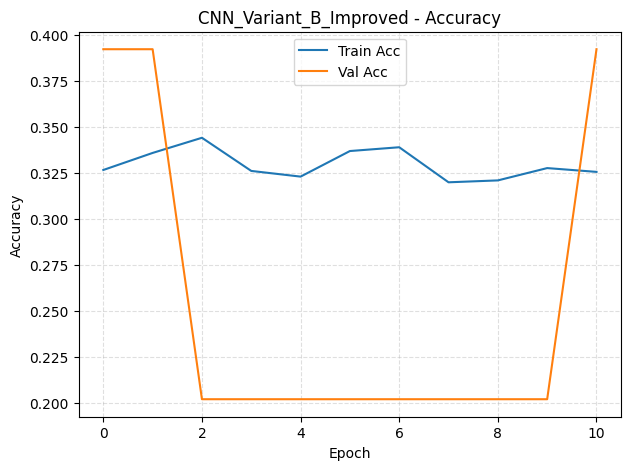

[INFO] Saved: outputs/curves/CNN_Variant_B_Improved_accuracy.png


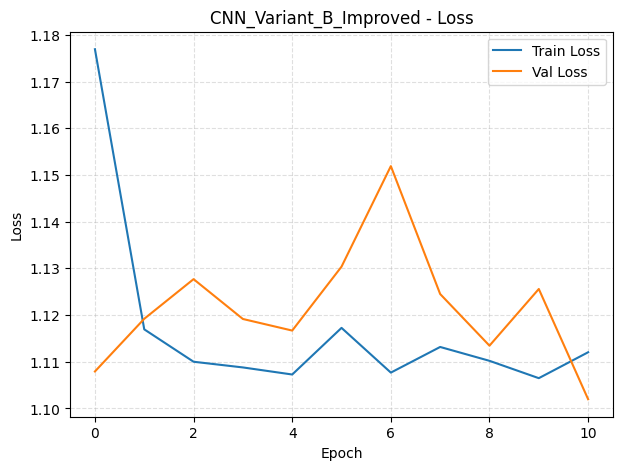

[INFO] Saved: outputs/curves/CNN_Variant_B_Improved_loss.png

[RESULTS] Best validation metrics (from current run):
 - CNN_Variant_B_Improved: best Val Acc = 0.3921 | best Val Loss = 1.1020


In [6]:
# ===============================================
# AER850 — STEP 4 (GPU-OPT + No Leakage + Resume)
# - Colab GPU with mixed precision (AMP)
# - EfficientNetV2B0 transfer learning
# - Strong aug on train only; clean val
# - Class-weights (optional) + resume checkpoints
# - Prefetch / parallel map / non-deterministic tf.data
# ===============================================

import os, json, math, gc, pathlib, collections, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# --------- ENV & GPU CONFIG ----------
print("[ENV] TF", tf.__version__)
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"[ENV] GPU(s) detected: {len(gpus)} | Mixed precision ON")
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')  # AMP
    else:
        print("[ENV] No GPU detected; will still run (slower). Mixed precision skipped.")
except Exception as e:
    print(f"[WARN] GPU setup issue: {e}")

AUTOTUNE = tf.data.AUTOTUNE

# --------- Preconditions from Step 1 ----------
need = ['PATH_TRAIN','PATH_VAL','IMG_HEIGHT','IMG_WIDTH','IMG_CH']
missing = [x for x in need if x not in globals()]
if missing:
    raise RuntimeError(f"Missing {missing}. Run Step 1 first to define paths & image shape.")

PATH_TRAIN = pathlib.Path(PATH_TRAIN)
PATH_VAL   = pathlib.Path(PATH_VAL)

# --------- Config knobs (GPU friendly) ----------
TRAIN_BOTH      = False      # if you still want to train Variant A too
EPOCHS          = 20         # AMP + transfer learning => can train a bit longer
PATIENCE        = 4
BATCH           = 32         # raise if VRAM allows (e.g., 48/64 on T4)
CAP_STEPS_TRAIN = None       # set small ints to cap if you're in a rush
CAP_STEPS_VAL   = None

# --------- Helpers ----------
def count_images_by_class(root_dir: pathlib.Path):
    """Count images per class directory (top-level subfolders)."""
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    counts = {}
    for d in sorted([p for p in root_dir.iterdir() if p.is_dir()]):
        c = 0
        for p, _, files in os.walk(d):
            c += sum(1 for f in files if pathlib.Path(f).suffix.lower() in exts)
        counts[d.name] = c
    return counts

def make_class_weights(train_root: pathlib.Path, class_names):
    """Compute class weights dict {index: weight} for imbalanced data."""
    counts = count_images_by_class(train_root)
    # Map to indices
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    total = sum(counts.get(c,0) for c in class_names)
    if total == 0:
        return None
    weights = {}
    for c in class_names:
        n = counts.get(c, 0)
        if n == 0:
            # Avoid div-by-zero: give a large weight if a class exists in labels but has no files
            weights[class_to_idx[c]] = 0.0
        else:
            weights[class_to_idx[c]] = total / (len(class_names) * n)
    return weights

# --------- Dataset builders (GPU optimized, no leakage) ----------
def make_datasets(batch_size=BATCH):
    # Base datasets (no rescale/aug yet)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        PATH_TRAIN,
        labels='inferred',
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        PATH_VAL,
        labels='inferred',
        label_mode='categorical',
        shuffle=False,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
    )

    class_names = train_ds.class_names
    num_classes = len(class_names)
    print(f"[DATA] Classes ({num_classes}): {class_names}")

    # Augment (train only) + Rescale (both)
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.07),
        tf.keras.layers.RandomZoom(0.12),
        tf.keras.layers.RandomTranslation(0.08, 0.08),
        tf.keras.layers.RandomContrast(0.12),
    ], name="gpu_aug")

    rescale = tf.keras.layers.Rescaling(1./255.0, name="rescale")

    # Non-deterministic pipeline for throughput
    opt = tf.data.Options()
    opt.experimental_deterministic = False

    train_ds = train_ds.map(
        lambda x,y: (rescale(aug(x, training=True)), y),
        num_parallel_calls=AUTOTUNE
    ).with_options(opt).prefetch(AUTOTUNE)

    val_ds = val_ds.map(
        lambda x,y: (rescale(x, training=False), y),
        num_parallel_calls=AUTOTUNE
    ).with_options(opt).prefetch(AUTOTUNE)

    # Steps (optional caps)
    def _card(ds):
        try:
            return int(tf.data.experimental.cardinality(ds).numpy())
        except Exception:
            return None

    steps_train = _card(train_ds)
    steps_val   = _card(val_ds)
    if CAP_STEPS_TRAIN is not None and steps_train is not None:
        steps_train = min(CAP_STEPS_TRAIN, steps_train)
    if CAP_STEPS_VAL is not None and steps_val is not None:
        steps_val   = min(CAP_STEPS_VAL, steps_val)

    # Class weights (optional)
    class_weights = make_class_weights(PATH_TRAIN, class_names)

    return train_ds, val_ds, steps_train, steps_val, num_classes, class_names, class_weights

# --------- Models (transfer learning + your fallbacks) ----------
def build_transfer_model(input_shape, num_classes):
    from tensorflow.keras import layers, Model, regularizers
    # EfficientNetV2B0 backbone (imagenet). Works well for 224x224; other sizes okay too.
    base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights='imagenet', input_shape=input_shape
    )
    base.trainable = False  # phase 1: train top only

    inputs = layers.Input(shape=input_shape)
    x = inputs  # images already rescaled
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.3, name="head_do")(x)
    x = layers.Dense(256, activation='gelu',
                     kernel_regularizer=regularizers.l2(1e-5),
                     name="head_dense")(x)
    x = layers.Dropout(0.3, name="head_do2")(x)
    # IMPORTANT: keep final softmax in float32 for numerical stability w/ AMP
    logits = layers.Dense(num_classes, dtype='float32', activation='softmax', name='pred')(x)

    model = Model(inputs, logits, name="EffNetV2B0_head")
    return model, base

def get_models():
    items = []
    # Prefer transfer model as your "Improved" one
    INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CH)
    # If your earlier MODELS are around, we can still attach them; but transfer is best
    # Build transfer model as B
    model_b, base_b = build_transfer_model(INPUT_SHAPE, num_classes=3)  # will correct num_classes after dataset
    items.append(("CNN_Variant_B_Improved", model_b))
    # Optional: also include your baseline A if you want
    if TRAIN_BOTH:
        # Simple baseline A (small convnet)
        from tensorflow.keras import Model
        from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                             Dense, Dropout, BatchNormalization, LeakyReLU, Activation)
        def block(x, f, bn=False, lrelu=False, pfx='cb'):
            x = Conv2D(f, 3, padding='same', kernel_initializer='he_normal', name=f'{pfx}_conv')(x)
            if bn: x = BatchNormalization(name=f'{pfx}_bn')(x)
            x = (LeakyReLU(0.1, name=f'{pfx}_lrelu') if lrelu else Activation('relu', name=f'{pfx}_relu'))(x)
            x = MaxPooling2D(2, name=f'{pfx}_pool')(x); return x
        inp = Input(INPUT_SHAPE)
        x = block(inp,32,pfx='a1'); x = block(x,64,pfx='a2'); x = block(x,128,pfx='a3'); x = block(x,256,pfx='a4')
        x = Flatten(name='a_flatten')(x); x = Dense(128, activation='relu', name='a_fc')(x); x = Dropout(0.5, name='a_do')(x)
        outA = Dense(3, activation='softmax', dtype='float32', name='a_softmax')(x)
        model_a = Model(inp, outA, name='CNN_Variant_A_Baseline')
        items.insert(0, ("CNN_Variant_A_Baseline", model_a))
    for n, m in items:
        try: print(f" - {n}: params={m.count_params():,}")
        except: pass
    return items

# --------- Callbacks & plotting ----------
def make_callbacks(tag):
    os.makedirs("models", exist_ok=True)
    os.makedirs("outputs/histories", exist_ok=True)
    return [
        ModelCheckpoint(f"models/{tag}_best.keras", monitor='val_accuracy', mode='max',
                        save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        CSVLogger(f"outputs/histories/{tag}_log.csv", append=True),
    ]

def plot_curves(history, tag):
    os.makedirs("outputs/curves", exist_ok=True)
    with open(f"outputs/histories/{tag}_history.json", "w") as f:
        json.dump(history.history, f, indent=2)
    # Accuracy
    plt.figure(figsize=(7,5))
    plt.plot(history.history.get('accuracy', []), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', []), label='Val Acc')
    plt.title(f'{tag} - Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()
    ap = f"outputs/curves/{tag}_accuracy.png"; plt.savefig(ap, bbox_inches='tight', dpi=150); plt.show()
    print(f"[INFO] Saved: {ap}")
    # Loss
    plt.figure(figsize=(7,5))
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.title(f'{tag} - Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()
    lp = f"outputs/curves/{tag}_loss.png"; plt.savefig(lp, bbox_inches='tight', dpi=150); plt.show()
    print(f"[INFO] Saved: {lp}")

# --------- Train with resume + fine-tune ----------
def compile_model(model, lr=2e-3):
    # Adam works well with AMP; outputs are float32 already on last layer
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

def fine_tune_unfreeze(model, base, pct=0.6, lr=5e-4):
    """Unfreeze last pct of layers in base for fine-tuning."""
    if base is None:
        return
    # Unfreeze last pct of layers
    n = len(base.layers)
    cut = int(n * (1.0 - pct))
    for i, layer in enumerate(base.layers):
        layer.trainable = (i >= cut)
    print(f"[FT] Unfroze last {pct*100:.0f}% of backbone layers ({n-cut}/{n}).")
    # Compile with lower LR
    compile_model(model, lr=lr)

def train_gpu(model, tag, class_weights=None, do_finetune=True):
    # Resume if checkpoint exists (safe)
    ckpt_path = f"models/{tag}_best.keras"
    if os.path.exists(ckpt_path):
        try:
            model = tf.keras.models.load_model(ckpt_path)
            print(f"[INFO] Resumed from checkpoint: {ckpt_path}")
        except Exception as e:
            print(f"[WARN] Could not load checkpoint ({e}). Training fresh.")

    # Build datasets (get true num_classes from data)
    train_ds, val_ds, steps_train, steps_val, num_classes, class_names, cw = make_datasets(BATCH)

    # If transfer model was created with 3 classes but your dataset has N != 3, rebuild once
    if model.output_shape[-1] != num_classes:
        from tensorflow.keras import layers, Model
        x = model.layers[-2].output  # take penultimate layer
        out = layers.Dense(num_classes, activation='softmax', dtype='float32', name='pred')(x)
        model = Model(model.input, out, name=model.name)
        print(f"[INFO] Adjusted classifier to num_classes={num_classes}")

    # Prefer dataset-derived class weights
    if cw is not None:
        class_weights = cw
        print("[DATA] Using class weights:", class_weights)

    # Phase 1: train head
    compile_model(model, lr=2e-3)
    print("\n" + "="*80)
    print(f"[TRAIN GPU - PHASE 1] {tag} | batch={BATCH} | epochs={EPOCHS} | steps: train={steps_train} val={steps_val}")
    print("="*80)
    hist1 = model.fit(
        train_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_train,
        validation_data=val_ds,
        validation_steps=steps_val,
        callbacks=make_callbacks(tag),
        class_weight=class_weights,
        verbose=1
    )

    # Phase 2: fine-tune backbone (optional)
    hist2 = None
    if do_finetune:
        base = None
        # Try to find the EfficientNet base by name
        for l in model.layers:
            if isinstance(l, tf.keras.Model) and 'efficientnetv2' in l.name:
                base = l
                break
        # If not found (because we rebuilt outputs), try the nested layer approach
        if base is None:
            for l in model.layers:
                if hasattr(l, 'name') and 'efficientnetv2' in l.name:
                    base = l
                    break

        if base is not None:
            fine_tune_unfreeze(model, base, pct=0.6, lr=5e-4)
            print("\n" + "="*80)
            print(f"[TRAIN GPU - PHASE 2 FT] {tag} | batch={BATCH} | +unfrozen last 60% of backbone")
            print("="*80)
            hist2 = model.fit(
                train_ds,
                epochs=max(6, PATIENCE+2),  # a few more epochs for FT
                steps_per_epoch=steps_train,
                validation_data=val_ds,
                validation_steps=steps_val,
                callbacks=make_callbacks(tag),
                class_weight=class_weights,
                verbose=1
            )
        else:
            print("[FT] EfficientNet base not found; skipped fine-tuning.")

    # Merge histories
    class HWrap:
        def __init__(self, h1, h2):
            self.history = collections.defaultdict(list)
            for k,v in h1.history.items(): self.history[k].extend(v)
            if h2 is not None:
                for k,v in h2.history.items(): self.history[k].extend(v)
    return HWrap(hist1, hist2)

# =========================
# RUN
# =========================
models_to_train = get_models()
H = {}
for tag, model in models_to_train:
    hist = train_gpu(model, tag, class_weights=None, do_finetune=True)
    H[tag] = dict(hist.history)
    plot_curves(hist, tag)
    tf.keras.backend.clear_session(); gc.collect()

print("\n[RESULTS] Best validation metrics (from current run):")
for tag, hist in H.items():
    bacc = float(np.max(hist.get('val_accuracy', [np.nan])))
    bloss = float(np.min(hist.get('val_loss',     [np.nan])))
    print(f" - {tag}: best Val Acc = {bacc:.4f} | best Val Loss = {bloss:.4f}")

In [ ]:
# ===============================================
# AER850 — STEP 4 (CPU-ONLY + Budget + Resume)
# - Forces CPU (no GPU required)
# - No mixed precision
# - Capped steps/epochs for speed
# - Uses image_dataset_from_directory + prefetch on CPU
# ===============================================

import os, json, math, gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# -------- Force CPU: hide any GPU device, disable mixed precision --------
try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # must be set before TF runtime init
except Exception:
    pass

# Re-import TF runtime visibility (in case loaded earlier)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices([], 'GPU')
        print("[INFO] GPU devices hidden. Running on CPU.")
    except Exception as e:
        print(f"[WARN] Could not hide GPUs: {e}")
else:
    print("[INFO] No GPU visible. Running on CPU.")

# Ensure no mixed precision on CPU
print("[INFO] Mixed precision disabled for CPU runs.")

# -------- Preconditions (paths + shape from Step 1) --------
need = ['PATH_TRAIN','PATH_VAL','IMG_HEIGHT','IMG_WIDTH','IMG_CH']
missing = [x for x in need if x not in globals()]
if missing:
    raise RuntimeError(f"Missing {missing}. Run Step 1 first to define paths & image shape.")

# -------- Config knobs (CPU-friendly defaults) --------
TRAIN_BOTH      = False   # set True to also train Variant A (slower)
EPOCHS          = 10      # keep modest; EarlyStopping will stop earlier
PATIENCE        = 3
BATCH_CPU       = 8       # smaller batch for CPU memory/time
CAP_STEPS_TRAIN = 40      # cap steps/epoch to finish faster (None = full)
CAP_STEPS_VAL   = 12
AUTOTUNE        = tf.data.AUTOTUNE

# -------- Dataset builders (CPU-efficient) --------
def make_datasets(batch_size=BATCH_CPU):
    # image_dataset_from_directory returns float32 tensors in [0,255]; add rescaling & aug in pipeline
    train_ds = tf.keras.utils.image_dataset_from_directory(
        PATH_TRAIN,
        labels='inferred',
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        PATH_VAL,
        labels='inferred',
        label_mode='categorical',
        shuffle=False,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
    )

    # Augment (train only) + Rescale (both)
    aug = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255.0),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.03),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.05, 0.05),
    ], name="cpu_aug")

    rescale_only = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255.0)
    ], name="cpu_rescale")

    train_ds = (train_ds
                .map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))
    val_ds   = (val_ds
                .map(lambda x,y: (rescale_only(x, training=False), y), num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))

    # Optionally cap steps/epoch
    steps_train = None
    steps_val   = None
    if CAP_STEPS_TRAIN is not None:
        steps_train = min(CAP_STEPS_TRAIN, tf.data.experimental.cardinality(train_ds).numpy())
    if CAP_STEPS_VAL is not None:
        steps_val   = min(CAP_STEPS_VAL,   tf.data.experimental.cardinality(val_ds).numpy())

    return train_ds, val_ds, steps_train, steps_val

# -------- Bring/build models (Step 3 -> Step 2 -> inline fallback) --------
def get_models():
    items = []
    source = None
    if 'MODELS' in globals() and isinstance(MODELS, dict):
        a = MODELS.get("A_relu_relu_32-64-128-256_adam1e-3")
        b = MODELS.get("B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2")
        if TRAIN_BOTH and a is not None:
            items.append(("CNN_Variant_A_Baseline", a))
        # Always train B if present
        if b is not None:
            items.append(("CNN_Variant_B_Improved", b))
        source = "Step 3 MODELS"
    elif 'build_cnn_variant_a' in globals() and 'build_cnn_variant_b' in globals():
        if TRAIN_BOTH:
            items.append(("CNN_Variant_A_Baseline", build_cnn_variant_a()))
        items.append(("CNN_Variant_B_Improved", build_cnn_variant_b()))
        source = "Step 2 builders"
    else:
        # Inline fallback (assignment compliant)
        from tensorflow.keras import Model
        from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                             Dense, Dropout, BatchNormalization, LeakyReLU, Activation)
        INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CH); NUM_CLASSES = 3
        def block(x, f, bn=False, lrelu=False, pfx='cb'):
            x = Conv2D(f, 3, padding='same', kernel_initializer='he_normal', name=f'{pfx}_conv')(x)
            if bn: x = BatchNormalization(name=f'{pfx}_bn')(x)
            x = (LeakyReLU(0.1, name=f'{pfx}_lrelu') if lrelu else Activation('relu', name=f'{pfx}_relu'))(x)
            x = MaxPooling2D(2, name=f'{pfx}_pool')(x); return x
        # A
        inp = Input(INPUT_SHAPE)
        x = block(inp,32,'',False,'a1'); x = block(x,64,pfx='a2'); x = block(x,128,pfx='a3'); x = block(x,256,pfx='a4')
        x = Flatten(name='a_flatten')(x); x = Dense(128, activation='relu', name='a_fc')(x); x = Dropout(0.5, name='a_do')(x)
        outA = Dense(NUM_CLASSES, activation='softmax', name='a_softmax')(x)
        model_a = Model(inp, outA, name='CNN_Variant_A_Baseline')
        # B
        inp2 = Input(INPUT_SHAPE)
        y = block(inp2,64,True,True,'b1'); y = block(y,128,True,True,'b2'); y = block(y,256,True,True,'b3'); y = block(y,256,True,True,'b4')
        y = Flatten(name='b_flatten')(y); y = Dense(256, activation='elu', name='b_fc')(y); y = Dropout(0.6, name='b_do')(y)
        outB = Dense(NUM_CLASSES, activation='softmax', name='b_softmax')(y)
        model_b = Model(inp2, outB, name='CNN_Variant_B_Improved')
        if TRAIN_BOTH:
            items.append(("CNN_Variant_A_Baseline", model_a))
        items.append(("CNN_Variant_B_Improved", model_b))
        source = "Inline fallback"
    print(f"[INFO] Using models from: {source}")
    for n, m in items:
        try:
            print(f" - {n}: params={m.count_params():,}")
        except Exception:
            pass
    if not items:
        raise RuntimeError("No models resolved. Ensure Step 2/3 built models.")
    return items

# -------- Callbacks & plotting --------
def make_callbacks(tag):
    os.makedirs("models", exist_ok=True)
    os.makedirs("outputs/histories", exist_ok=True)
    return [
        ModelCheckpoint(f"models/{tag}_best.keras", monitor='val_accuracy', mode='max',
                        save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        CSVLogger(f"outputs/histories/{tag}_log.csv", append=True),
    ]

def plot_curves(history, tag):
    os.makedirs("outputs/curves", exist_ok=True)
    with open(f"outputs/histories/{tag}_history.json", "w") as f:
        json.dump(history.history, f, indent=2)
    # Accuracy
    plt.figure(figsize=(7,5))
    plt.plot(history.history.get('accuracy', []), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', []), label='Val Acc')
    plt.title(f'{tag} - Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()
    ap = f"outputs/curves/{tag}_accuracy.png"; plt.savefig(ap, bbox_inches='tight', dpi=150); plt.show()
    print(f"[INFO] Saved: {ap}")
    # Loss
    plt.figure(figsize=(7,5))
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.title(f'{tag} - Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()
    lp = f"outputs/curves/{tag}_loss.png"; plt.savefig(lp, bbox_inches='tight', dpi=150); plt.show()
    print(f"[INFO] Saved: {lp}")

# -------- Train (CPU) with resume checkpoint --------
def train_cpu(model, tag):
    # Compile fresh (CPU, no mixed precision)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Resume if checkpoint exists
    ckpt_path = f"models/{tag}_best.keras"
    if os.path.exists(ckpt_path):
        try:
            model = tf.keras.models.load_model(ckpt_path)
            print(f"[INFO] Resumed from checkpoint: {ckpt_path}")
        except Exception as e:
            print(f"[WARN] Could not load checkpoint ({e}). Training fresh.")

    # Build datasets
    train_ds, val_ds, steps_train, steps_val = make_datasets(BATCH_CPU)
    if steps_train is None or steps_train == 0 or steps_val is None or steps_val == 0:
        raise RuntimeError("Empty train/val datasets. Check your directory structure and paths.")

    print("\n" + "="*80)
    print(f"[TRAIN CPU] {tag} | batch_size={BATCH_CPU} | epochs={EPOCHS} | caps: train={steps_train} val={steps_val}")
    print("="*80)

    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_train,
        validation_data=val_ds,
        validation_steps=steps_val,
        callbacks=make_callbacks(tag),
        verbose=1
    )
    return history

# =========================
# RUN
# =========================
models_to_train = get_models()
H = {}
for tag, model in models_to_train:
    hist = train_cpu(model, tag)
    H[tag] = hist.history
    plot_curves(hist, tag)
    tf.keras.backend.clear_session(); gc.collect()

print("\n[RESULTS] Best validation metrics (from current run):")
for tag, hist in H.items():
    bacc = float(np.max(hist.get('val_accuracy', [np.nan])))
    bloss = float(np.min(hist.get('val_loss',     [np.nan])))
    print(f" - {tag}: best Val Acc = {bacc:.4f} | best Val Loss = {bloss:.4f}")


# Step 5: Model Testing
The final component of this project is testing the model that was trained. This involves loading test images and predicting the class of that image from the model designed. Test- ing the model requires the following steps:
• Data processing of test images to convert the images to the format of that of the in- put data utilized for the model trained. Use the image package from keras prepro- cessing to load the image, convert the image to an array, and normalize it by divid- ing the image by 255.
• Since this is a multi-class classification problem and the final model layer uses the softmax activation function, you would need to find the maximum probability from the model’s prediction.
• The final prediction of the image is expected to look similar to Figure 3 shown be- low.

In [ ]:
# STEP 5 TEST

My version

In [7]:
# =========================
# AER850 — STEP 1 (PyTorch): Data + Dataloaders
# - Copies dataset from Drive -> /content (fast)
# - Uses torchvision ImageFolder
# - Train aug only; clean val/test
# - Saves label_map.json
# =========================

import os, shutil, json, pathlib, random, math
from collections import Counter
import numpy as np
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ---------- USER: set Drive paths ----------
DRIVE_TRAIN = "/content/drive/MyDrive/AER 850/Project 2/train"
DRIVE_VAL   = "/content/drive/MyDrive/AER 850/Project 2/valid"
DRIVE_TEST  = "/content/drive/MyDrive/AER 850/Project 2/test"

# ---------- Copy to local SSD (fast) ----------
def copy_to_local(src, dst):
    src, dst = pathlib.Path(src), pathlib.Path(dst)
    if not src.exists():
        raise FileNotFoundError(f"Missing: {src}")
    if not dst.exists():
        print(f"[DATA] Copying {src} -> {dst} ...")
        shutil.copytree(src, dst)
    else:
        print(f"[DATA] Using cached local copy: {dst}")
    return str(dst)

PATH_TRAIN = copy_to_local(DRIVE_TRAIN, "/content/dataset/train")
PATH_VAL   = copy_to_local(DRIVE_VAL,   "/content/dataset/val")
PATH_TEST  = copy_to_local(DRIVE_TEST,  "/content/dataset/test")

# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manualSeed = torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False  # allow perf
torch.backends.cudnn.benchmark = True       # speed on fixed image sizes

# ---------- Core params ----------
IMG_SIZE   = 256
BATCH_SIZE = 64     # try 64 on T4; reduce to 48 if OOM
NUM_WORKERS= 4      # try 2-4 in Colab; 0 if issues
PIN_MEMORY = True

# ---------- Transforms ----------
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.06,0.06))], p=0.8),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
    transforms.ToTensor(),
    # EfficientNet expects [0,1] + specific norm; we’ll normalize in Step 4 to match weights
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ---------- Datasets ----------
train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
val_ds   = datasets.ImageFolder(PATH_VAL,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(PATH_TEST,  transform=eval_tfms)

class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
NUM_CLASSES  = len(class_to_idx)

print("[INFO] Classes:", class_to_idx)

# ---------- Counts + class weights ----------
def count_images_per_class(root):
    counts = Counter()
    for cls_name, idx in datasets.ImageFolder(root).class_to_idx.items():
        cls_dir = pathlib.Path(root)/cls_name
        counts[cls_name] = len([p for p in cls_dir.rglob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".gif",".tiff",".webp")])
    return counts

train_counts = count_images_per_class(PATH_TRAIN)
total = sum(train_counts.values())
weights = {class_to_idx[c]: total / (NUM_CLASSES * max(1, n)) for c, n in train_counts.items()}
print("[INFO] Train counts:", dict(train_counts))
print("[INFO] Class weights (for loss):", weights)

# ---------- Dataloaders ----------
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS>0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS>0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=NUM_WORKERS>0)

# ---------- Save label map ----------
os.makedirs("outputs", exist_ok=True)
with open("outputs/label_map.json","w") as f:
    json.dump(class_to_idx, f, indent=2)
print('[INFO] Saved "outputs/label_map.json"')

# Export globals for later steps
globals().update(dict(
    PATH_TRAIN=PATH_TRAIN, PATH_VAL=PATH_VAL, PATH_TEST=PATH_TEST,
    IMG_SIZE=IMG_SIZE, NUM_CLASSES=NUM_CLASSES, class_to_idx=class_to_idx, idx_to_class=idx_to_class,
    BATCH_SIZE=BATCH_SIZE, NUM_WORKERS=NUM_WORKERS, PIN_MEMORY=PIN_MEMORY,
    train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, class_weights=weights
))


[DATA] Copying /content/drive/MyDrive/AER 850/Project 2/train -> /content/dataset/train ...
[DATA] Copying /content/drive/MyDrive/AER 850/Project 2/valid -> /content/dataset/val ...
[DATA] Copying /content/drive/MyDrive/AER 850/Project 2/test -> /content/dataset/test ...
[INFO] Classes: {'crack': 0, 'missing-head': 1, 'paint-off': 2}
[INFO] Train counts: {'crack': 676, 'missing-head': 661, 'paint-off': 605}
[INFO] Class weights (for loss): {0: 0.9575936883629191, 1: 0.9793242561775088, 2: 1.0699724517906337}
[INFO] Saved "outputs/label_map.json"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# =========================
# AER850 — STEP 2 (PyTorch): CNN Architectures
# - Baseline A (ReLU)
# - Improved B (BN + LeakyReLU + ELU head + L2)
# - USE_GAP=True recommended (or False to keep Flatten-like behavior)
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F

USE_GAP = True  # set False if rubric requires Flatten-like behavior

def _conv_block(in_ch, out_ch, use_bn=False, use_lrelu=False):
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=not use_bn)]
    if use_bn: layers.append(nn.BatchNorm2d(out_ch))
    layers.append(nn.LeakyReLU(0.1, inplace=True) if use_lrelu else nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CNN_Variant_A_Baseline(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            _conv_block(3, 32, use_bn=False, use_lrelu=False),  # 256->128
            _conv_block(32, 64, use_bn=False, use_lrelu=False), # 128->64
            _conv_block(64,128, use_bn=False, use_lrelu=False), # 64->32
            _conv_block(128,256, use_bn=False, use_lrelu=False) # 32->16
        )
        if USE_GAP:
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            )
        else:
            # Extra pool (16->8) to control params before flatten
            self.preflat = nn.MaxPool2d(2)  # 16->8
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256*8*8, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            )

    def forward(self, x):
        x = self.features(x)
        if USE_GAP:
            return self.head(x)
        x = self.preflat(x)
        return self.head(x)

class CNN_Variant_B_Improved(nn.Module):
    def __init__(self, num_classes=3, l2=1e-4):
        super().__init__()
        self.features = nn.Sequential(
            _conv_block(3,  64, use_bn=True, use_lrelu=True),  # 256->128
            _conv_block(64,128, use_bn=True, use_lrelu=True),  # 128->64
            _conv_block(128,256, use_bn=True, use_lrelu=True), # 64->32
            _conv_block(256,256, use_bn=True, use_lrelu=True), # 32->16
        )
        if USE_GAP:
            self.head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                nn.Linear(256, 256), nn.ELU(inplace=True),
                nn.BatchNorm1d(256), nn.Dropout(0.6),
                nn.Linear(256, num_classes)
            )
        else:
            self.preflat = nn.MaxPool2d(2)  # 16->8
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256*8*8, 256), nn.ELU(inplace=True),
                nn.BatchNorm1d(256), nn.Dropout(0.6),
                nn.Linear(256, num_classes)
            )
        self.l2 = l2

    def forward(self, x):
        x = self.features(x)
        if USE_GAP:
            return self.head(x)
        x = self.preflat(x)
        return self.head(x)

# Quick param counts
def count_params(m):
    return sum(p.numel() for p in m.parameters())

model_a = CNN_Variant_A_Baseline(num_classes=NUM_CLASSES)
model_b = CNN_Variant_B_Improved(num_classes=NUM_CLASSES)

print(f"[INFO] A params: {count_params(model_a):,}")
print(f"[INFO] B params: {count_params(model_b):,}")

# Export builders
globals().update(dict(CNN_Variant_A_Baseline=CNN_Variant_A_Baseline,
                      CNN_Variant_B_Improved=CNN_Variant_B_Improved))


[INFO] A params: 421,699
[INFO] B params: 1,028,675


In [9]:
# =========================
# AER850 — STEP 3 (PyTorch): Hyperparameter candidates (no training yet)
# =========================

import pandas as pd

HP_TRIALS = [
    {"name":"A_relu_adam1e-3",         "model":"A", "optimizer":"adam",    "lr":1e-3,  "label_smooth":0.00, "weight_decay":0.0},
    {"name":"B_lrelu_elu_adam1e-3_l2", "model":"B", "optimizer":"adam",    "lr":1e-3,  "label_smooth":0.00, "weight_decay":1e-4},
    {"name":"A_relu_sgd2e-2",          "model":"A", "optimizer":"sgd",     "lr":2e-2,  "label_smooth":0.00, "weight_decay":0.0},
    {"name":"B_lrelu_rms5e-4",         "model":"B", "optimizer":"rmsprop", "lr":5e-4,  "label_smooth":0.00, "weight_decay":0.0},
]

rows = []
for hp in HP_TRIALS:
    m = CNN_Variant_B_Improved(NUM_CLASSES) if hp["model"]=="B" else CNN_Variant_A_Baseline(NUM_CLASSES)
    rows.append({"name":hp["name"], "model":hp["model"], "optimizer":hp["optimizer"],
                 "lr":hp["lr"], "label_smooth":hp["label_smooth"],
                 "weight_decay":hp["weight_decay"], "params":sum(p.numel() for p in m.parameters())})

df = pd.DataFrame(rows)
print(df)

# Export
import os, json
os.makedirs("outputs", exist_ok=True)
with open("outputs/hparam_candidates_pytorch.json","w") as f:
    json.dump(HP_TRIALS, f, indent=2)
globals().update(dict(HP_TRIALS=HP_TRIALS))


                      name model optimizer      lr  label_smooth  \
0          A_relu_adam1e-3     A      adam  0.0010           0.0   
1  B_lrelu_elu_adam1e-3_l2     B      adam  0.0010           0.0   
2           A_relu_sgd2e-2     A       sgd  0.0200           0.0   
3          B_lrelu_rms5e-4     B   rmsprop  0.0005           0.0   

   weight_decay   params  
0        0.0000   421699  
1        0.0001  1028675  
2        0.0000   421699  
3        0.0000  1028675  


[ENV] cuda
[DATA] Class weights: {'crack': 0.9575936794281006, 'missing-head': 0.9793242812156677, 'paint-off': 1.0699723958969116}

================ PHASE 1 (head only) ================


/tmp/ipython-input-3276159149.py:114: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-3276159149.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01/20 | train_loss=0.8698 acc=0.6900 | val_loss=0.7384 acc=0.7610 | lr=7.50e-04 | 31.6s
  [CKPT] Improved val_acc -> 0.7610
Epoch 02/20 | train_loss=0.6402 acc=0.7925 | val_loss=0.6321 acc=0.7935 | lr=7.50e-04 | 11.8s
  [CKPT] Improved val_acc -> 0.7935
Epoch 03/20 | train_loss=0.5761 acc=0.8074 | val_loss=0.5886 acc=0.7865 | lr=7.50e-04 | 12.7s
Epoch 04/20 | train_loss=0.5400 acc=0.8275 | val_loss=0.5622 acc=0.8260 | lr=7.50e-04 | 12.4s
  [CKPT] Improved val_acc -> 0.8260
Epoch 05/20 | train_loss=0.5134 acc=0.8404 | val_loss=0.5470 acc=0.8144 | lr=7.50e-04 | 12.3s
Epoch 06/20 | train_loss=0.4818 acc=0.8646 | val_loss=0.5269 acc=0.8353 | lr=7.50e-04 | 12.5s
  [CKPT] Improved val_acc -> 0.8353
Epoch 07/20 | train_loss=0.4824 acc=0.8610 | val_loss=0.5255 acc=0.8260 | lr=7.50e-04 | 13.2s
Epoch 08/20 | train_loss=0.4678 acc=0.8677 | val_loss=0.5175 acc=0.8306 | lr=7.50e-04 | 13.0s
Epoch 09/20 | train_loss=0.4648 acc=0.8656 | val_loss=0.5164 acc=0.8445 | lr=7.50e-04 | 11.4s
  [CKPT] I

/tmp/ipython-input-3276159149.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):



[VAL] Classification report:
              precision    recall  f1-score   support

       crack       0.92      0.97      0.94       175
missing-head       0.99      0.91      0.94       169
   paint-off       0.90      0.97      0.93        87

    accuracy                           0.94       431
   macro avg       0.94      0.95      0.94       431
weighted avg       0.94      0.94      0.94       431

Confusion matrix:
 [[169   2   4]
 [ 11 153   5]
 [  3   0  84]]


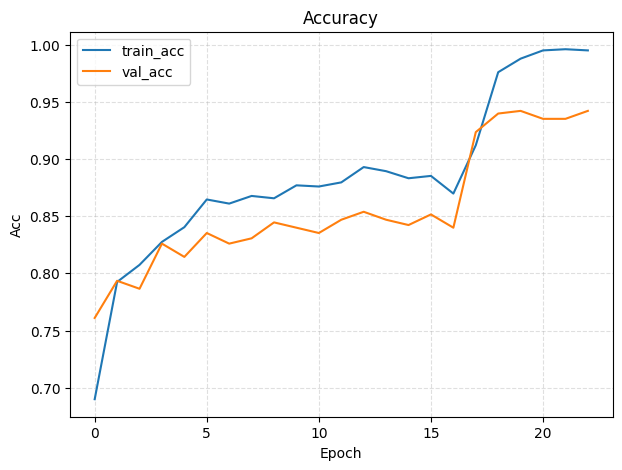

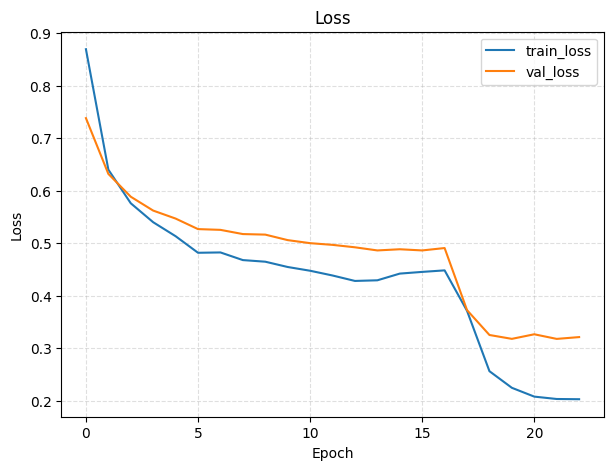

In [12]:
# ===============================================
# AER850 — STEP 4 (PyTorch): EfficientNet-B0 + AMP (fixed)
# - Removes 'verbose' from ReduceLROnPlateau (older PT builds)
# - Uses NUM_WORKERS=2 (per Colab warning)
# - Everything else unchanged: AMP, class-weights, early-stop, FT
# ===============================================

import os, time, json, numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[ENV]", device)

# ---- defaults from Step 1 (override if missing) ----
IMG_SIZE    = globals().get("IMG_SIZE", 256)
BATCH_SIZE  = globals().get("BATCH_SIZE", 64)
NUM_WORKERS = 2   # <- keep 2 to avoid Colab worker warning
PIN_MEMORY  = globals().get("PIN_MEMORY", True)

assert "PATH_TRAIN" in globals() and "PATH_VAL" in globals(), "Run Step 1 first."
assert "NUM_CLASSES" in globals(), "Run Step 1 first."

# ---- robust ImageNet normalization ----
from torchvision.models import EfficientNet_B0_Weights
weights_enum = EfficientNet_B0_Weights.IMAGENET1K_V1
try:
    _tfms = weights_enum.transforms()
    _norms = [t for t in getattr(_tfms, "transforms", []) if isinstance(t, transforms.Normalize)]
    if _norms:
        mean, std = _norms[0].mean, _norms[0].std
    else:
        raise RuntimeError("Normalize not in weights transforms")
except Exception:
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.06,0.06))], p=0.8),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(PATH_TRAIN, transform=train_tfms)
val_ds   = datasets.ImageFolder(PATH_VAL,   transform=eval_tfms)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=NUM_WORKERS > 0
)

# ---- class weights ----
def count_images_per_class(root):
    tmp = datasets.ImageFolder(root)
    counts = Counter()
    for cname, idx in tmp.class_to_idx.items():
        cdir = os.path.join(root, cname)
        n = sum(1 for r,_,files in os.walk(cdir)
                for f in files if os.path.splitext(f)[1].lower() in (".jpg",".jpeg",".png",".bmp",".gif",".tiff",".webp"))
        counts[cname] = n
    return counts

class_to_idx_local = train_ds.class_to_idx
idx_to_class_local = {v:k for k,v in class_to_idx_local.items()}
NUM_CLASSES_LOCAL  = len(class_to_idx_local)
assert NUM_CLASSES_LOCAL == NUM_CLASSES, "Class count changed between steps."

train_counts = count_images_per_class(PATH_TRAIN)
total = sum(train_counts.values())
weights = {class_to_idx_local[c]: total / (NUM_CLASSES_LOCAL * max(1, n)) for c, n in train_counts.items()}
w = torch.tensor([weights[i] for i in range(NUM_CLASSES_LOCAL)], dtype=torch.float32, device=device)
print("[DATA] Class weights:", {idx_to_class_local[i]: float(w[i].cpu().numpy()) for i in range(NUM_CLASSES_LOCAL)})

# ---- model ----
from torchvision.models import efficientnet_b0
def build_effnet_b0(num_classes):
    m = efficientnet_b0(weights=weights_enum)
    in_feats = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_feats, num_classes)
    return m

model = build_effnet_b0(NUM_CLASSES_LOCAL).to(device)

# speed knobs
torch.backends.cudnn.benchmark = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

# ---- optim/sched/loss ----
lr_head = 7.5e-4
optimizer = optim.Adam(model.parameters(), lr=lr_head, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # <- no 'verbose'
scaler = GradScaler(enabled=torch.cuda.is_available())

label_smooth = 0.05
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=label_smooth).to(device)

# ---- loops ----
def run_epoch(loader, train=True):
    model.train(train)
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

def evaluate_preds(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            logits = model(imgs)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
    return np.array(y_true), np.array(y_pred)

def save_ckpt(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

def load_ckpt(path):
    model.load_state_dict(torch.load(path, map_location=device))

# ---- phase 1: train head ----
for p in model.features.parameters():    p.requires_grad = False
for p in model.classifier.parameters():  p.requires_grad = True

EPOCHS, PATIENCE = 20, 4
best_val_acc, best_path = 0.0, "models/CNN_Variant_B_Improved_best.pt"
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
no_improve = 0

print("\n================ PHASE 1 (head only) ================")
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        vl_loss, vl_acc = run_epoch(val_loader, train=False)
    scheduler.step(vl_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss);   history["val_acc"].append(vl_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={vl_loss:.4f} acc={vl_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

    if vl_acc > best_val_acc:
        best_val_acc = vl_acc; save_ckpt(best_path); no_improve = 0
        print(f"  [CKPT] Improved val_acc -> {best_val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("  [EARLY STOP] No improvement. Stopping Phase 1.")
            break

# ---- phase 2: fine-tune last ~80% ----
print("\n================ PHASE 2 (fine-tune) ================")
load_ckpt(best_path)

feat_params = list(model.features.parameters())
cut = int(len(feat_params) * 0.2)  # unfreeze last 80%
for i, p in enumerate(feat_params):
    p.requires_grad = (i >= cut)

for g in optimizer.param_groups:
    g['lr'] = 3e-4

no_improve = 0
for epoch in range(1, max(6, PATIENCE+2)+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        vl_loss, vl_acc = run_epoch(val_loader, train=False)
    scheduler.step(vl_loss)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss);   history["val_acc"].append(vl_acc)

    print(f"[FT] Epoch {epoch:02d} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={vl_loss:.4f} acc={vl_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

    if vl_acc > best_val_acc:
        best_val_acc = vl_acc; save_ckpt(best_path); no_improve = 0
        print(f"  [CKPT] Improved val_acc -> {best_val_acc:.4f}")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("  [EARLY STOP] No improvement. Stopping FT.")
            break

print(f"\n[RESULT] Best val_acc: {best_val_acc:.4f}")

# ---- eval + plots ----
from sklearn.metrics import classification_report, confusion_matrix
load_ckpt(best_path)
y_true, y_pred = evaluate_preds(val_loader)
print("\n[VAL] Classification report:")
print(classification_report(y_true, y_pred, target_names=[idx_to_class_local[i] for i in range(NUM_CLASSES_LOCAL)]))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

os.makedirs("outputs/curves", exist_ok=True)
plt.figure(figsize=(7,5))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
plt.grid(True, ls="--", alpha=0.4); plt.legend()
plt.savefig("outputs/curves/effnet_acc.png", dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(7,5))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, ls="--", alpha=0.4); plt.legend()
plt.savefig("outputs/curves/effnet_loss.png", dpi=150, bbox_inches="tight"); plt.show()


In [13]:
# ===============================================
# AER850 — STEP 5 (PyTorch): Model Testing (Accurate + Efficient)
# - Loads best saved model (.pt)
# - Uses same normalization as training (EffNet-B0 ImageNet stats)
# - Softmax -> top-1 class + prob
# - Saves annotated images to outputs/preds/
# ===============================================

import os, json, torch
import numpy as np
from PIL import Image, ImageDraw
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn.functional as F

# -------- Config --------
PREFERRED_MODEL_TAG = "CNN_Variant_B_Improved"        # matches Step 4
BEST_CKPT_PATH      = f"models/{PREFERRED_MODEL_TAG}_best.pt"  # produced by Step 4
os.makedirs("outputs/preds", exist_ok=True)

# Required test images (relative to PATH_TEST)
TEST_IMAGE_LIST = [
    ("test/crack/test_crack.jpg", "crack"),
    ("test/missing-head/test_missinghead.jpg", "missing-head"),
    ("test/paint-off/test_paintoff.jpg", "paint-off"),
]

# -------- Preconditions (from Step 1) --------
assert "PATH_TEST" in globals() and os.path.isdir(PATH_TEST), "Run Step 1 (PyTorch) first to define PATH_TEST."
assert "PATH_TRAIN" in globals() and os.path.isdir(PATH_TRAIN), "Run Step 1 (PyTorch) first to define PATH_TRAIN."
assert "IMG_SIZE" in globals(), "IMG_SIZE must be defined (from Step 1)."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[ENV]", device)

# -------- Class names (same order as training) --------
# We re-create a tiny ImageFolder on the TRAIN set to recover the exact class_to_idx used.
train_tmp = datasets.ImageFolder(PATH_TRAIN)  # no transforms needed
class_to_idx = train_tmp.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
NUM_CLASSES  = len(idx_to_class)
print("[INFO] Classes:", idx_to_class)

# -------- Normalization (exactly as Step 4) --------
weights_enum = EfficientNet_B0_Weights.IMAGENET1K_V1
try:
    _tfms = weights_enum.transforms()
    _norms = [t for t in getattr(_tfms, "transforms", []) if isinstance(t, transforms.Normalize)]
    if _norms:
        mean, std = _norms[0].mean, _norms[0].std
    else:
        raise RuntimeError("Normalize not in weights transforms")
except Exception:
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# -------- Model rebuild + load best checkpoint --------
def build_effnet_b0(num_classes):
    m = efficientnet_b0(weights=None)             # no weights; we will load our trained checkpoint
    in_feats = m.classifier[1].in_features
    m.classifier[1] = torch.nn.Linear(in_feats, num_classes)
    return m

if not os.path.exists(BEST_CKPT_PATH):
    raise FileNotFoundError(f"Best checkpoint not found: {BEST_CKPT_PATH}")

model = build_effnet_b0(NUM_CLASSES).to(device)
ckpt = torch.load(BEST_CKPT_PATH, map_location=device)
model.load_state_dict(ckpt)
model.eval()
print(f"[INFO] Loaded checkpoint: {BEST_CKPT_PATH}")

# -------- Utilities --------
def load_image_tensor(path):
    img = Image.open(path).convert("RGB")
    return test_tfms(img).unsqueeze(0)  # [1,3,H,W]

def annotate_and_save(src_path, pred_label, prob, out_path):
    img = Image.open(src_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    header_h = max(40, img.height // 18)
    draw.rectangle([0, 0, img.width, header_h], fill=(0, 0, 0))
    text = f"Pred: {pred_label} ({prob:.2%})"
    draw.text((10, max(5, (header_h - 16) // 2)), text, fill=(255, 255, 255))
    img.save(out_path)

# -------- Predict on required test images --------
for rel_path, expected in TEST_IMAGE_LIST:
    # Build absolute path from PATH_TEST (mirrors your TF tester behavior)
    parts = rel_path.split("/")  # ["test", "<class>", "file.jpg"]
    img_path = os.path.join(PATH_TEST, *parts[1:]) if parts and parts[0] == "test" else os.path.join(PATH_TEST, rel_path)
    if not os.path.exists(img_path):
        print(f"[WARN] Missing: {img_path}  (expected: {expected})")
        continue

    x = load_image_tensor(img_path).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits.float(), dim=1)[0].cpu().numpy()  # (C,)
    top_idx = int(np.argmax(probs))
    top_label = idx_to_class.get(top_idx, f"idx_{top_idx}")
    top_prob  = float(probs[top_idx])

    print(f"{os.path.basename(img_path)} -> Pred: {top_label} ({top_prob:.2%}) | Expected: {expected}")

    out_file = os.path.join("outputs", "preds", f"pred_{os.path.basename(img_path)}")
    try:
        annotate_and_save(img_path, top_label, top_prob, out_file)
        print(f"[INFO] Saved annotated: {out_file}")
    except Exception as e:
        print(f"[WARN] Could not annotate {img_path}: {e}")

# Optional: save a small JSON log of predictions
# os.makedirs("outputs", exist_ok=True)
# with open("outputs/test_preds.json","w") as f:
#     json.dump({"class_order":[idx_to_class[i] for i in range(NUM_CLASSES)],
#                "last_probs": list(map(float, probs))}, f, indent=2)


[ENV] cuda
[INFO] Classes: {0: 'crack', 1: 'missing-head', 2: 'paint-off'}
[INFO] Loaded checkpoint: models/CNN_Variant_B_Improved_best.pt
test_crack.jpg -> Pred: crack (98.09%) | Expected: crack
[INFO] Saved annotated: outputs/preds/pred_test_crack.jpg
test_missinghead.jpg -> Pred: missing-head (98.25%) | Expected: missing-head
[INFO] Saved annotated: outputs/preds/pred_test_missinghead.jpg
test_paintoff.jpg -> Pred: paint-off (99.36%) | Expected: paint-off
[INFO] Saved annotated: outputs/preds/pred_test_paintoff.jpg



[TEST] Classification report:
              precision    recall  f1-score   support

       crack     0.9282    0.9194    0.9238       211
missing-head     0.9750    0.9750    0.9750       200
   paint-off     0.9077    0.9219    0.9147       128

    accuracy                         0.9406       539
   macro avg     0.9370    0.9388    0.9378       539
weighted avg     0.9407    0.9406    0.9406       539



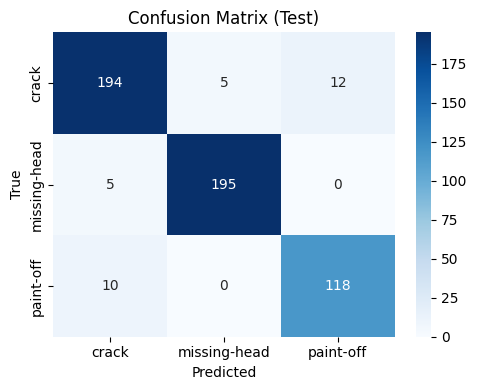

[INFO] Saved confusion matrix to "outputs/curves/test_confusion_matrix.png"
[INFO] Saved per-image predictions to "outputs/test_predictions.csv"


In [14]:
# =========================
# AER850 — STEP 5B: Full test evaluation + artifacts
# - Accuracy, classification report
# - Confusion matrix PNG
# - CSV with per-image preds + probs
# =========================
import os, csv, json, numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # if missing: pip install seaborn
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert "PATH_TEST" in globals() and os.path.isdir(PATH_TEST), "Run Step 1 (PyTorch) first."

# --- Class order (match training) ---
train_tmp = datasets.ImageFolder(PATH_TRAIN)
class_to_idx = train_tmp.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
NUM_CLASSES  = len(idx_to_class)

# --- Normalization (match Step 4) ---
from torchvision.models import EfficientNet_B0_Weights
weights_enum = EfficientNet_B0_Weights.IMAGENET1K_V1
try:
    _tfms = weights_enum.transforms()
    _norms = [t for t in getattr(_tfms, "transforms", []) if isinstance(t, transforms.Normalize)]
    mean, std = (_norms[0].mean, _norms[0].std) if _norms else ((0.485,0.456,0.406),(0.229,0.224,0.225))
except Exception:
    mean, std = (0.485,0.456,0.406), (0.229,0.224,0.225)

IMG_SIZE = globals().get("IMG_SIZE", 256)
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- Build test dataset/loader ---
test_ds = datasets.ImageFolder(PATH_TEST, transform=test_tfms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True
)

# --- Rebuild model & load best ckpt ---
def build_effnet_b0(num_classes):
    m = efficientnet_b0(weights=None)
    in_feats = m.classifier[1].in_features
    m.classifier[1] = torch.nn.Linear(in_feats, num_classes)
    return m

best_path = "models/CNN_Variant_B_Improved_best.pt"
model = build_effnet_b0(NUM_CLASSES).to(device)
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# --- Evaluate ---
all_y, all_pred, all_prob = [], [], []
all_paths = [p for (p, _) in test_ds.samples]  # absolute paths

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs = F.softmax(logits.float(), dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_y.extend(yb.numpy().tolist())
        all_pred.extend(preds.tolist())
        all_prob.extend(probs.tolist())

# --- Metrics ---
target_names = [idx_to_class[i] for i in range(NUM_CLASSES)]
print("\n[TEST] Classification report:")
print(classification_report(all_y, all_pred, target_names=target_names, digits=4))

cm = confusion_matrix(all_y, all_pred)
os.makedirs("outputs/curves", exist_ok=True)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig("outputs/curves/test_confusion_matrix.png", dpi=150)
plt.show()
print('[INFO] Saved confusion matrix to "outputs/curves/test_confusion_matrix.png"')

# --- CSV of per-image predictions ---
os.makedirs("outputs", exist_ok=True)
csv_path = "outputs/test_predictions.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    header = ["file", "true_label", "pred_label"] + [f"p_{c}" for c in target_names]
    w.writerow(header)
    for path, y, pred, prob in zip(all_paths, all_y, all_pred, all_prob):
        row = [os.path.basename(path), idx_to_class[y], idx_to_class[pred]] + list(map(lambda x: f"{x:.6f}", prob))
        w.writerow(row)
print(f'[INFO] Saved per-image predictions to "{csv_path}"')


In [17]:
# quick dup check by size+name (cheap) and pHash (strong)
import os, imagehash
from PIL import Image
from collections import defaultdict

def list_images(root):
    ok = {".jpg",".jpeg",".png",".bmp",".gif",".tiff",".webp"}
    paths=[]
    for r,_,fs in os.walk(root):
        for f in fs:
            if os.path.splitext(f)[1].lower() in ok:
                paths.append(os.path.join(r,f))
    return paths

def phash_map(paths):
    m={}
    for p in paths:
        try:
            h = imagehash.phash(Image.open(p).convert("RGB"))
            m[p]=h
        except: pass
    return m

train = list_images(PATH_TRAIN)
val   = list_images(PATH_VAL)
test  = list_images(PATH_TEST)

# filename + size heuristic
size_map = defaultdict(list)
for p in train+val+test:
    try: size_map[(os.path.basename(p), os.path.getsize(p))].append(p)
    except: pass
suspicious = [v for v in size_map.values() if len(v)>1 and
              any(PATH_TEST in x for x in v) and any(PATH_TRAIN in x or PATH_VAL in x for x in v)]
print("[HEURISTIC DUPS]", suspicious[:10])

# strong pHash cross-split check (may take a bit)
tr_hash = phash_map(train+val)
te_hash = phash_map(test)
overlaps = [(t, tr) for t,h in te_hash.items() for tr,hr in tr_hash.items() if (h-hr) <= 2]  # Hamming dist ≤2
print("[PHASH NEAR-DUPS]", overlaps[:10])


[HEURISTIC DUPS] []
[PHASH NEAR-DUPS] [('/content/dataset/test/crack/IMG_20230511_101055_jpg.rf.d6d6f95e4365a1fda10c0ecbd0a3bb5a.jpg', '/content/dataset/val/crack/IMG_20230511_101055_jpg.rf.45349fe06d85071464fdf6abe7ae8f88.jpg'), ('/content/dataset/test/crack/IMG_20230512_131448_jpg.rf.a4714b1bbe3db22d8923dea8b2128e6b.jpg', '/content/dataset/train/crack/IMG_20230512_131448_jpg.rf.0be19101827891550cd103f94762d2f3.jpg'), ('/content/dataset/test/missing-head/IMG_20230511_100609_jpg.rf.61d9f3b8629d83c8d963d82aa0f70d6d.jpg', '/content/dataset/train/missing-head/IMG_20230511_100609_jpg.rf.467549a38284ebf5d90c6ca515af4572.jpg'), ('/content/dataset/test/missing-head/IMG_20230512_121001_jpg.rf.2e1ae09fd59c66bd014682544f2ffa39.jpg', '/content/dataset/train/missing-head/IMG_20230512_121001_jpg.rf.0f47fe60168328ef127f3a71fb984205.jpg'), ('/content/dataset/test/missing-head/IMG_20230511_100550_jpg.rf.a764156c0261cf2fd2c9dcf1eced2d72.jpg', '/content/dataset/train/missing-head/IMG_20230511_100541_jpg